In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss

In [4]:
datadir = './tmud_input'

gatrain = pd.read_csv(os.path.join(datadir, 'gender_age_train.csv'),
                      index_col='device_id')
gatest = pd.read_csv(os.path.join(datadir, 'gender_age_test.csv'),
                     index_col='device_id')
phone = pd.read_csv(os.path.join(datadir, 'phone_brand_device_model.csv'))
# Get rid of duplicate device ids in phone
phone = phone.drop_duplicates('device_id', keep='first').set_index('device_id')
events = pd.read_csv(os.path.join(datadir, 'events.csv'),
                     parse_dates=['timestamp'], index_col='event_id')
appevents = pd.read_csv(os.path.join(datadir, 'app_events.csv'),
                        usecols=['event_id', 'app_id', 'is_active'],
                        dtype={'is_active': bool})
applabels = pd.read_csv(os.path.join(datadir, 'app_labels.csv'))

In [27]:
applabels.describe()

,app_id,label_id,app,label
count,7.820400e+04,78204.000000,78204.000000,78204.000000
mean,2.363879e+17,602.826901,9719.781085,277.310572
std,5.286476e+18,280.844496,5548.280504,107.666612
min,-9.221157e+18,2.000000,0.000000,0.000000
25%,-4.178675e+18,405.000000,4935.000000,246.000000
50%,3.548212e+16,711.000000,9788.000000,277.000000
75%,4.983003e+18,854.000000,14529.000000,380.000000
max,9.222488e+18,1021.000000,19236.000000,491.000000


In [5]:
gatrain['trainrow'] = np.arange(gatrain.shape[0])
gatest['testrow'] = np.arange(gatest.shape[0])

brandencoder = LabelEncoder().fit(phone.phone_brand)
phone['brand'] = brandencoder.transform(phone['phone_brand'])
gatrain['brand'] = phone['brand']
gatest['brand'] = phone['brand']
Xtr_brand = csr_matrix((np.ones(gatrain.shape[0]),
                       (gatrain.trainrow, gatrain.brand)))
Xte_brand = csr_matrix((np.ones(gatest.shape[0]),
                       (gatest.testrow, gatest.brand)))
print('Brand features: train shape {}, test shape {}'.format(Xtr_brand.shape, Xte_brand.shape))


m = phone.phone_brand.str.cat(phone.device_model)
modelencoder = LabelEncoder().fit(m)
phone['model'] = modelencoder.transform(m)
gatrain['model'] = phone['model']
gatest['model'] = phone['model']
Xtr_model = csr_matrix((np.ones(gatrain.shape[0]),
                       (gatrain.trainrow, gatrain.model)))
Xte_model = csr_matrix((np.ones(gatest.shape[0]),
                       (gatest.testrow, gatest.model)))
print('Model features: train shape {}, test shape {}'.format(Xtr_model.shape, Xte_model.shape))


appencoder = LabelEncoder().fit(appevents.app_id)
appevents['app'] = appencoder.transform(appevents.app_id)
napps = len(appencoder.classes_)
deviceapps = (appevents.merge(events[['device_id']], how='left',left_on='event_id',right_index=True)
                       .groupby(['device_id','app'])['app'].agg(['size'])
                       .merge(gatrain[['trainrow']], how='left', left_index=True, right_index=True)
                       .merge(gatest[['testrow']], how='left', left_index=True, right_index=True)
                       .reset_index())
deviceapps.head()

d = deviceapps.dropna(subset=['trainrow'])
Xtr_app = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.app)),
                      shape=(gatrain.shape[0],napps))
d = deviceapps.dropna(subset=['testrow'])
Xte_app = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.app)),
                      shape=(gatest.shape[0],napps))
print('Apps data: train shape {}, test shape {}'.format(Xtr_app.shape, Xte_app.shape))

applabels = applabels.loc[applabels.app_id.isin(appevents.app_id.unique())]
applabels['app'] = appencoder.transform(applabels.app_id)
labelencoder = LabelEncoder().fit(applabels.label_id)
applabels['label'] = labelencoder.transform(applabels.label_id)
nlabels = len(labelencoder.classes_)

devicelabels = (deviceapps[['device_id', 'app']]
                .merge(applabels[['app', 'label']])
                .groupby(['device_id', 'label'])['app'].agg(['size'])
                .merge(gatrain[['trainrow']], how='left', left_index=True, right_index=True)
                .merge(gatest[['testrow']], how='left', left_index=True, right_index=True)
                .reset_index())
devicelabels.head()

d = devicelabels.dropna(subset=['trainrow'])
Xtr_label = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.label)),
                      shape=(gatrain.shape[0],nlabels))
d = devicelabels.dropna(subset=['testrow'])
Xte_label = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.label)),
                      shape=(gatest.shape[0],nlabels))
print('Labels data: train shape {}, test shape {}'.format(Xtr_label.shape, Xte_label.shape))

Xtrain = hstack((Xtr_brand, Xtr_model, Xtr_app, Xtr_label), format='csr')
Xtest =  hstack((Xte_brand, Xte_model, Xte_app, Xte_label), format='csr')
print('All features: train shape {}, test shape {}'.format(Xtrain.shape, Xtest.shape))

targetencoder = LabelEncoder().fit(gatrain.group)
y = targetencoder.transform(gatrain.group)
nclasses = len(targetencoder.classes_)

Brand features: train shape (74645, 131), test shape (112071, 131)
Model features: train shape (74645, 1667), test shape (112071, 1667)
Apps data: train shape (74645, 19237), test shape (112071, 19237)
Labels data: train shape (74645, 492), test shape (112071, 492)
All features: train shape (74645, 21527), test shape (112071, 21527)


In [7]:
gatrain['trainrow'] = np.arange(gatrain.shape[0])
gatest['testrow'] = np.arange(gatest.shape[0])

In [9]:
brandencoder = LabelEncoder().fit(phone.phone_brand)
phone['brand'] = brandencoder.transform(phone['phone_brand'])
Xtr_brand = csr_matrix((np.ones(gatrain.shape[0]), 
                       (gatrain.trainrow, gatrain.brand)))
Xte_brand = csr_matrix((np.ones(gatest.shape[0]), 
                       (gatest.testrow, gatest.brand)))
print('Brand features: train shape {}, test shape {}'.format(Xtr_brand.shape, Xte_brand.shape))

Brand features: train shape (74645, 131), test shape (112071, 131)


In [10]:
m = phone.phone_brand.str.cat(phone.device_model)
modelencoder = LabelEncoder().fit(m)
phone['model'] = modelencoder.transform(m)
gatrain['model'] = phone['model']
gatest['model'] = phone['model']
Xtr_model = csr_matrix((np.ones(gatrain.shape[0]), 
                       (gatrain.trainrow, gatrain.model)))
Xte_model = csr_matrix((np.ones(gatest.shape[0]), 
                       (gatest.testrow, gatest.model)))
print('Model features: train shape {}, test shape {}'.format(Xtr_model.shape, Xte_model.shape))

Model features: train shape (74645, 1667), test shape (112071, 1667)


In [11]:
events.head()

,device_id,timestamp,longitude,latitude
event_id,,,,
1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70
4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28
5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66


In [12]:
appencoder = LabelEncoder().fit(appevents.app_id)
appevents['app'] = appencoder.transform(appevents.app_id)
napps = len(appencoder.classes_)
deviceapps = (appevents.merge(events[['device_id']], how='left',left_on='event_id',right_index=True)
                       .groupby(['device_id','app'])['app'].agg(['size'])
                       .merge(gatrain[['trainrow']], how='left', left_index=True, right_index=True)
                       .merge(gatest[['testrow']], how='left', left_index=True, right_index=True)
                       .reset_index())
deviceapps.head()

,device_id,app,size,trainrow,testrow
0,-9222956879900151005,548,18,21594.0,NaN
1,-9222956879900151005,1096,18,21594.0,NaN
2,-9222956879900151005,1248,26,21594.0,NaN
3,-9222956879900151005,1545,12,21594.0,NaN
4,-9222956879900151005,1664,18,21594.0,NaN


In [13]:
d = deviceapps.dropna(subset=['trainrow'])
Xtr_app = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.app)), 
                      shape=(gatrain.shape[0],napps))
d = deviceapps.dropna(subset=['testrow'])
Xte_app = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.app)), 
                      shape=(gatest.shape[0],napps))
print('Apps data: train shape {}, test shape {}'.format(Xtr_app.shape, Xte_app.shape))

Apps data: train shape (74645, 19237), test shape (112071, 19237)


In [14]:
applabels = applabels.loc[applabels.app_id.isin(appevents.app_id.unique())]
applabels['app'] = appencoder.transform(applabels.app_id)
labelencoder = LabelEncoder().fit(applabels.label_id)
applabels['label'] = labelencoder.transform(applabels.label_id)
nlabels = len(labelencoder.classes_)

In [15]:
devicelabels = (deviceapps[['device_id','app']]
                .merge(applabels[['app','label']])
                .groupby(['device_id','label'])['app'].agg(['size'])
                .merge(gatrain[['trainrow']], how='left', left_index=True, right_index=True)
                .merge(gatest[['testrow']], how='left', left_index=True, right_index=True)
                .reset_index())
devicelabels.head()

,device_id,label,size,trainrow,testrow
0,-9222956879900151005,117,1,21594.0,NaN
1,-9222956879900151005,120,1,21594.0,NaN
2,-9222956879900151005,126,1,21594.0,NaN
3,-9222956879900151005,138,2,21594.0,NaN
4,-9222956879900151005,147,2,21594.0,NaN


In [16]:
d = devicelabels.dropna(subset=['trainrow'])
Xtr_label = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.label)), 
                      shape=(gatrain.shape[0],nlabels))
d = devicelabels.dropna(subset=['testrow'])
Xte_label = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.label)), 
                      shape=(gatest.shape[0],nlabels))
print('Labels data: train shape {}, test shape {}'.format(Xtr_label.shape, Xte_label.shape))

Labels data: train shape (74645, 492), test shape (112071, 492)


In [17]:
Xtrain = hstack((Xtr_brand, Xtr_model, Xtr_app, Xtr_label), format='csr')
Xtest =  hstack((Xte_brand, Xte_model, Xte_app, Xte_label), format='csr')
print('All features: train shape {}, test shape {}'.format(Xtrain.shape, Xtest.shape))

All features: train shape (74645, 21527), test shape (112071, 21527)


In [61]:
targetencoder = LabelEncoder().fit(gatrain.group)
y = targetencoder.transform(gatrain.group)
nclasses = len(targetencoder.classes_)

In [93]:
def score(clf, random_state = 0):
    kf = StratifiedKFold(n_splits=5)
    pred = np.zeros((y.shape[0],nclasses))
    for itrain, itest in kf.split(Xtrain,y):
        Xtr, Xte = Xtrain[itrain, :], Xtrain[itest, :]
        ytr, yte = y[itrain], y[itest]
        clf.fit(Xtr, ytr)
        pred[itest,:] = clf.predict_proba(Xte)
        # Downsize to one fold only for kernels
        return log_loss(yte, pred[itest, :])
        print("{:.5f}".format(log_loss(yte, pred[itest,:])), end=' ')
    print('')
    return log_loss(y, pred)

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/s

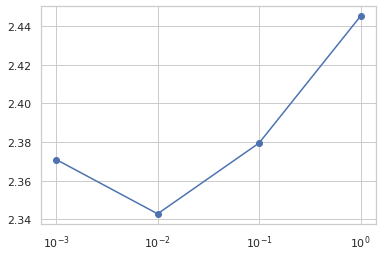

In [94]:
Cs = np.logspace(-3,0,4)
res = []
for C in Cs:
    res.append(score(LogisticRegression(C = C)))
plt.semilogx(Cs, res,'-o');

In [95]:
score(LogisticRegression(C=0.02))
score(LogisticRegression(C=0.02, multi_class='multinomial',solver='newton-cg'))
clf = LogisticRegression(C=0.02, multi_class='multinomial',solver='newton-cg')
clf.fit(Xtrain, y)
pred = pd.DataFrame(clf.predict_proba(Xtest), index = gatest.index, columns=targetencoder.classes_)
pred.head()
pred.to_csv('logreg_subm.csv',index=True)

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
